<a href="https://colab.research.google.com/github/tanyakuznetsova/IMDB_Sentiment_Analysis/blob/main/IMDB_Sentiment_Analysis_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification of IMDB reviews


Binary classification of the [50000 movie reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download) according to their sentiment analysis label - positive or negative. In this notebook I will be using a number of models to classify the reviews, including logistic regression, Naive Bayes, SVM and cosine similarity.

We will finetune the most successful models, compare their performance against a baseline model, and evaluate them using several metrics, such as balanced error rate, mean squared error and accuracy.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv('https://bitbucket.org/silverxlibra/imdb/downloads/IMDB_Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#print(df.isnull().sum)
print(df.isna().any())

review       False
sentiment    False
dtype: bool


In [ ]:
print(df['sentiment'].nunique())
print(df['sentiment'].unique())

2
['positive' 'negative']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.describe(include = 'all')

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
df.review.duplicated().sum() #are there any identical reviews?

418

In [ ]:
df.loc[df.review.duplicated()][:20] #let's have a look at the first 20 reviews that are the same

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
6672,Sigh. I'm baffled when I see a short like this...,negative
7221,"I have always been a huge fan of ""Homicide: Li...",positive
7222,There are plenty of comments already posted sa...,negative
7425,"The movie was excellent, save for some of the ...",positive
7555,This movie has made me upset! When I think of ...,negative


The reviews seem genuine and not one liners, but since they occur more than once, let's keep only one and drop the rest:

In [ ]:
df.drop_duplicates(inplace = True)

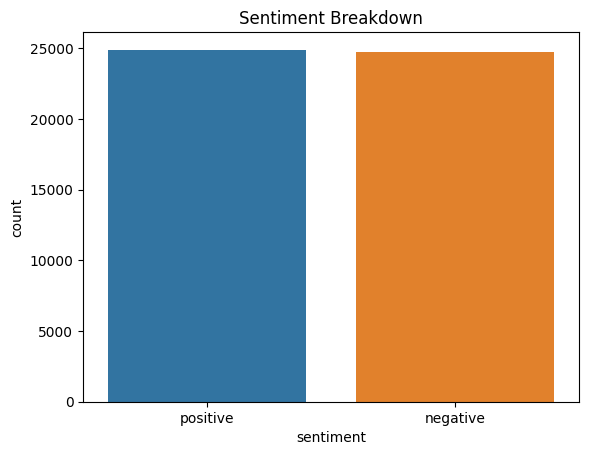

In [ ]:
import seaborn as sns
sns.countplot(x= df['sentiment'])
plt.title('Sentiment Breakdown')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


The exploratory analysis shows that this is a clean dataset with 50/50 split of positive and negative reviews and no missing values. There was a relatively small number (418) entries that were duplicates, and even though that is less than 1% (0.836% to be exact) of the entries, those are removed.

Next step: recode the categorical sentiment labels into binary numerical ones for machine learning using `LabelEncoder()` from `sklearn`.

# Word Clouds

Lets visualize the popular words that occur in reviews divided by sentiment. Let's create a word cloud for each sentiment and compare.

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

positive_reviews = " ".join(word for word in df.loc[df.sentiment == 'positive', 'review'])
negative_reviews = " ".join(word for word in df.loc[df.sentiment == 'negative', 'review'])

How many words are there in these strings we've just created?

In [ ]:
print('There are {} words in the positive reviews and {} words in the negative reviews'.format(len(positive_reviews), len(negative_reviews)))

There are 33027998 words in the positive reviews and 32002176 words in the negative reviews


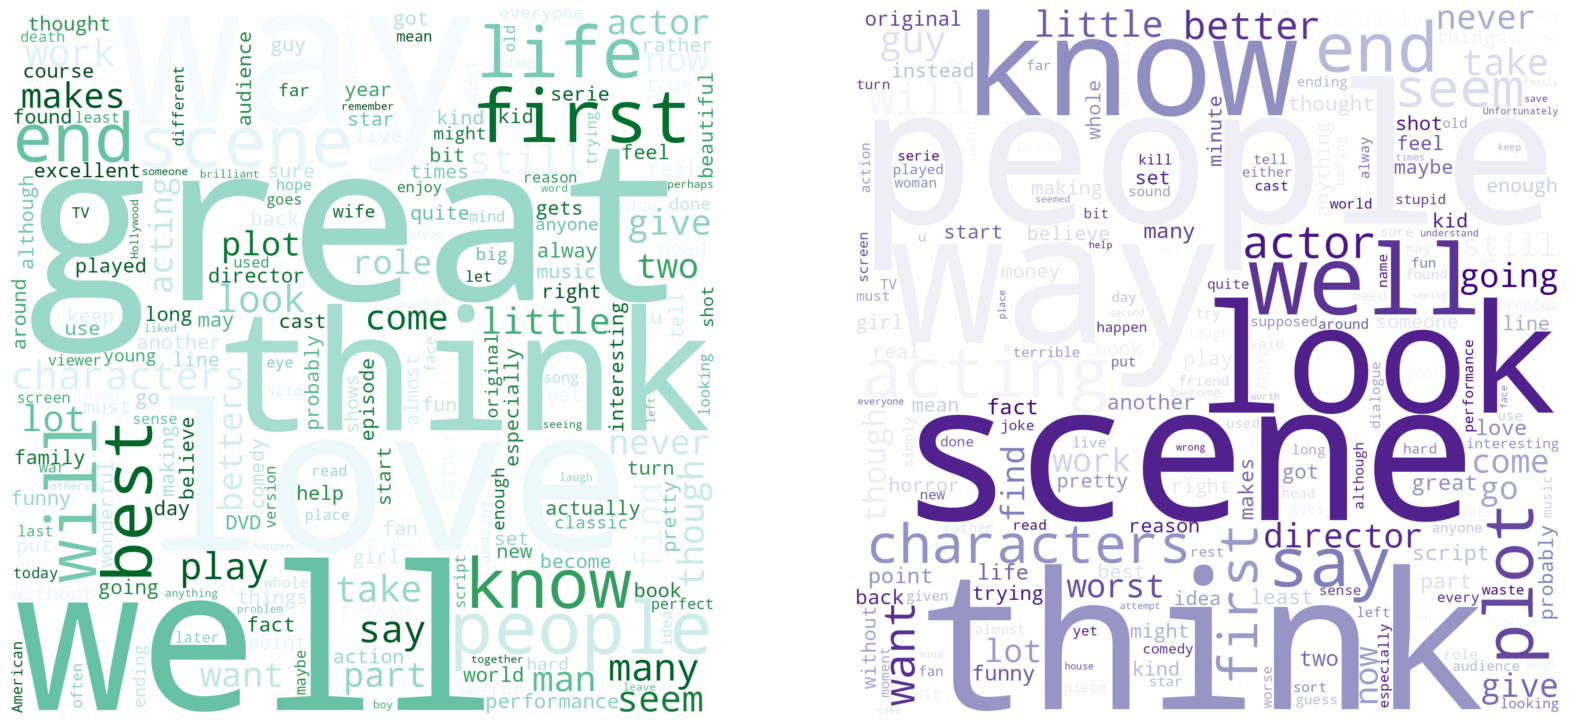

In [ ]:
stopwords = ['br', 'movie', 'film', 'show', 'movies', 'films',
             'watch', 'watching', 'watched', 'see', 'saw', 'seen',
             'one', 'something', 'everything', 'nothing', 'thing', 'much',
             'make', 'made', 'character', 'story',
             'really', 'even', 'time', 'good', 'bad'] + list(STOPWORDS)
wordcloud_pos = WordCloud(stopwords = stopwords,
                          background_color = 'white',
                          colormap = 'BuGn',
                          width = 1600,
                          height = 1600,
                          min_font_size = 10).generate(positive_reviews)

wordcloud_neg = WordCloud(stopwords = stopwords,
                          background_color = 'white',
                          colormap = 'Purples',
                          width = 1600,
                          height = 1600,
                          min_font_size = 10).generate(negative_reviews)

plt.figure(figsize = (20, 20))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos,
           interpolation = 'bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg,
           interpolation = 'bilinear')
plt.axis('off')
plt.show()

This visualization immediatedly gives us some representation as to what people tend to say about movies they liked and hated. It is a snapshot and not perfect, but gives us an overall idea of what reviewers pay attention to and what matters to them.
A few of the obvious frequently occurring words ('movie', 'good', watch', etc) are excluded since they would not be very informative because we know the subject matter.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sentiment = le.fit_transform(df.sentiment)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Text Vectorization

Transforming the raw text of the reviews into machine-readable vectors.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

#creating the vectorized data and storing it in a variable X
X = vectorizer.fit_transform(df['review'])

In [ ]:
print(type(X))

<class 'scipy.sparse._csr.csr_matrix'>


We now have a sparse matrix and are ready to feed it to a machine learning algorithm.

# Logistic Regression Model

Training and testing a logistic regression model on the training data:

In [ ]:
from sklearn.model_selection import train_test_split as tts
y = df.sentiment

X_train, X_test, y_train, y_test = tts(X, y,
                                       test_size = 0.2,
                                       train_size = 0.8,
                                       random_state = 100,
                                       shuffle = True)

In [ ]:
print(X_train.shape[0], X_test.shape[0], len(y_train), len(y_test)) #sanity checks

39665 9917 39665 9917


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 100,
                         max_iter = 100000)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8986588686094585

In [ ]:
y_pred_train = clf.predict(X_train) #creating predictions on the training set

from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_pred_train))

0.931677801588302


93.17% accuracy on the train test straight out of the box is not bad at all, but what can be expected on unseen data? Let's do some cross-validation.


In [ ]:
from sklearn.model_selection import KFold, cross_val_score #not LeaveOneOut bc the dataset is fairly large

#trying several values of k
k_values = [4, 5, 8, 10, 16]
accuracies = []
for k in k_values:
  kfold = KFold(n_splits = k,
              shuffle = True,
              random_state = 42)
  acc = cross_val_score(estimator = clf,
                      X = X_train,
                      y = y_train,
                      cv = kfold)
  accuracy = np.mean(acc) #average accuracy per k_value

  accuracies.append(accuracy)

print(accuracies)

[0.8918694461122924, 0.8936341863103493, 0.8943905169627737, 0.8950461262551705, 0.8960796700347434]


# Hyperparameter Tuning


89% is the accuracy we can expect on the test data, and while that's not a bad result, we can attempt some model finetuning by trying a couple of different hyperparameters:


*   different solvers rather than the default 'lbfgs'
*   regularization C
*   penalty



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'solver': ('lbfgs', 'sag', 'saga'),
    'C' : ([0.01, 0.1, 1]),
    'penalty' : ('l2', None)
}

grdsrch = GridSearchCV(estimator = clf,
                       param_grid = param_grid)

grdsrch.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

GridSearchCV(estimator=LogisticRegression(max_iter=100000, random_state=100),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ('l2', None),
                         'solver': ('lbfgs', 'sag', 'saga')})

In [ ]:
best_params = grdsrch.best_params_
print(best_params)

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


Testing further with different values for the regulirizer C:

In [ ]:
from sklearn.model_selection import GridSearchCV

grdsrch_for_best_C = GridSearchCV(estimator = clf,
                                param_grid = {'C': np.linspace(0.1, 10, num = 10)})
grdsrch_for_best_C.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=100000, random_state=100),
             param_grid={'C': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ])})

In [ ]:
best_params_C = grdsrch_for_best_C.best_params_
print(best_params_C)

{'C': 4.5}


Testing the hyperparameters suggests that the default solver lbfgs and the default penalty is in fact best! As far as the regularization term C goes, C = 4.5 outperforms the other tested values. So let's update the basic logistic regression model with the new C and test its performance.

In [ ]:
logreg = LogisticRegression(penalty = 'l2',
                         C = 4.5,
                         random_state = 100,
                         max_iter = 100000)

logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)
predictions = logreg.predict(X_train)

train_acc_ = accuracy_score(y_train, predictions)
print(train_acc_)

0.9676541031135762


In [ ]:
y_pred = logreg.predict(X_test)

test_acc_ = accuracy_score(y_test, y_pred)
print('Logistic regression test accuracy after hyperparameter tuning:', test_acc_*100, '%')

Logistic regression test accuracy after hyperparameter tuning: 90.37007159423213 %


In [ ]:
y_pred_ = clf.predict(X_test)

test_acc_old = accuracy_score(y_test, y_pred_)
print('Logistic regression test accuracy before hyperparameter tuning', test_acc_old * 100, '%')

Logistic regression test accuracy before hyperparameter tuning 89.86588686094585 %


That is a very slight improvement on the test data, despite being quite promising on the training data, where the increase was from 93.17% to 96.77%.

# Logistic Regression Model Evaluation

Sentiment analysis classification is a fairly difficult task due to inherent ambiguity; so I'd like to compare its performance to a baseline model, for example, Naive Bayes.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

baseline_model = MultinomialNB(alpha = 0.5,
                               force_alpha = True) #allowing for some smoothing

baseline_model.fit(X_train, y_train)

print('Baseline Naive Bayes model accuracy:', baseline_model.score(X_test, y_test)*100, '%')

Baseline Naive Bayes model accuracy: 86.53826762125642 %


So in fact the logistic regression model does perform better than the baseline naive Bayes. Finally, let's look at precision, recall, F1 and area under the curve.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4904
           1       0.90      0.91      0.91      5013

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



All the figures are very encouraging, the scores of 0.90-0.91 across the board. Let's plot the Receiver Operating characteristic and AUC.

In [ ]:
from sklearn.metrics import roc_curve, auc
#getting the predicted probabilities for the positive class
probabilities = logreg.predict_proba(X_test)
y_score = probabilities[:, 1]

fpr, tpr, threshold  = roc_curve(y_test, y_score, pos_label = 1)
roc_auc = auc(fpr, tpr)

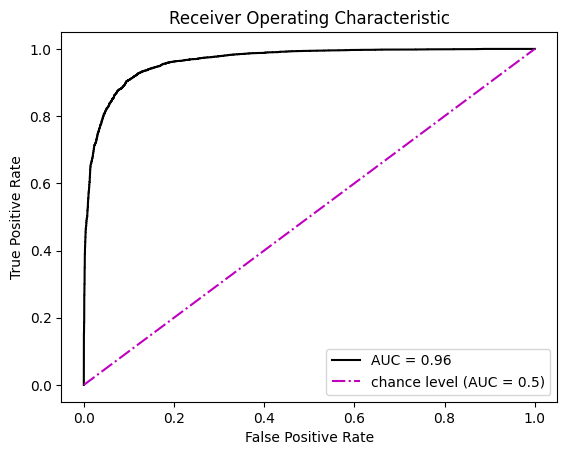

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr,
         color = 'k',
         label = 'AUC = %0.2f' % roc_auc)

plt.plot([0,1], [0,1], 'm-.',
         label = 'chance level (AUC = 0.5)')

plt.legend(loc  = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So we can see that the ROC curve is indeed approaching a near-perfect classifier and AUC = 0.96 is a very decent result.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

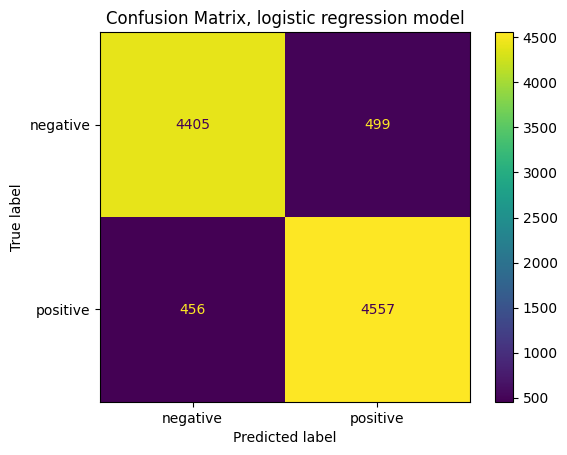

In [ ]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test,
                                                    display_labels = ('negative', 'positive'))
plt.title('Confusion Matrix, logistic regression model')
plt.show()

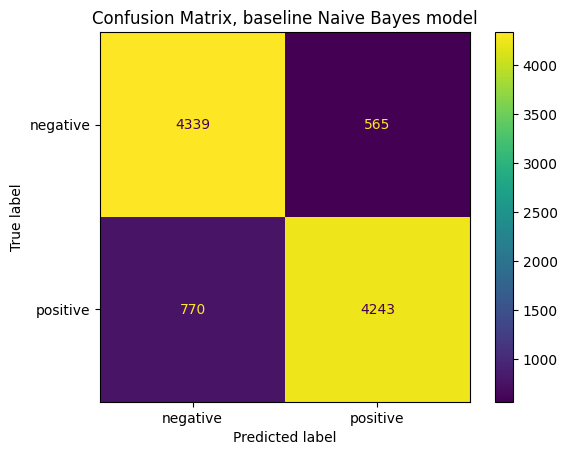

In [ ]:
ConfusionMatrixDisplay.from_estimator(baseline_model, X_test, y_test,
                                                       display_labels = ('negative', 'positive'))
plt.title('Confusion Matrix, baseline Naive Bayes model')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

MSE_LR = mean_squared_error(y_test, y_pred)
print('Mean sqared error of the finetuned logistic regression:', MSE_LR)

Mean sqared error of the finetuned logistic regression: 0.09629928405767874


In [ ]:
y_pred_NB = baseline_model.predict(X_test)
MSE_NB = mean_squared_error(y_test, y_pred_NB)
print('Mean sqared error of the Naive Bayes baseline model:', MSE_NB)

Mean sqared error of the Naive Bayes baseline model: 0.1346173237874357


This further confirms that the finetuned logistic regression outperforms the Naive Bayes as it has a lower mean squared error.

In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
BER_LR = 0.5*(FP/(TN + FP) + FN/(TP+ FN))
print('Balanced Error Rate of the finetuned logistic regression:', BER_LR)

Balanced Error Rate of the finetuned logistic regression: 0.09635858269315441


In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_NB).ravel()
BER_NB = 0.5*(FP/(TN + FP) + FN/(TP+ FN))
print('Balanced Error Rate of the baseline Naive Bayes model:', BER_NB)

Balanced Error Rate of the baseline Naive Bayes model: 0.13440635505922774


The logistic regression also has a lower balanced error rate than the baseline Naive Bayes, all evidence consistently pointing to the logistic regression being the better model overall.

# Model: Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
type(X_train)

scipy.sparse._csr.csr_matrix

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
cs = cosine_similarity(X_train.T, y_train.values.reshape(1,-1))

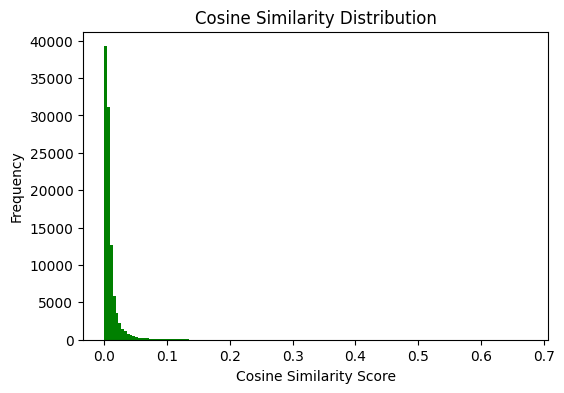

In [ ]:
plt.figure(figsize=(6,4))

plt.hist(cs, bins=150, color='green')

plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.show()

This graph shows most of the data received relatively low cosine similarity scores, meaning the vectors have weak similarity.

# Model: Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(penalty = 'l2',
                       loss = 'hinge',
                       max_iter = 10000).fit(X_train, y_train)

print('Linear SVM model test accuracy:', linear_svc.score(X_test, y_test)*100, '%')

Linear SVM model test accuracy: 90.34990420490068 %


In [ ]:
print('Linear SVM model train accuracy:', linear_svc.score(X_train, y_train)*100, '%')

Linear SVM model train accuracy: 95.99394932560192 %


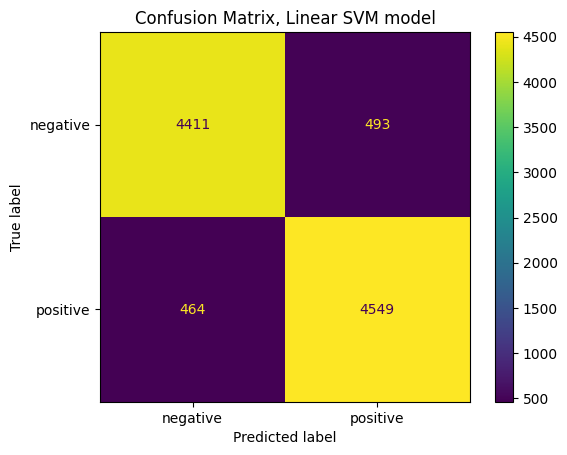

In [ ]:
ConfusionMatrixDisplay.from_estimator(linear_svc, X_test, y_test,
                                                    display_labels = ('negative', 'positive'))
plt.title('Confusion Matrix, Linear SVM model')
plt.show()

In [ ]:
svm_y_pred = linear_svc.predict(X_test)
MSE_SVM = mean_squared_error(y_test, svm_y_pred)
print('Mean sqared error of the Linear SVM model:', MSE_SVM)

Mean sqared error of the Linear SVM model: 0.09650095795099324


Finetuning Linear SVM for a better regularizer constant C:

In [ ]:
grdsrch_SVM = GridSearchCV(estimator = linear_svc,
                          param_grid = {'C': np.linspace(0.1, 10, num = 10),
                                        'loss': ('hinge', 'squared_hinge'),
                                        })
grdsrch_SVM.fit(X_train, y_train)

GridSearchCV(estimator=LinearSVC(loss='hinge', max_iter=10000),
             param_grid={'C': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
                         'loss': ('hinge', 'squared_hinge')})

In [ ]:
grdsrch_SVM.best_params_

{'C': 1.2000000000000002, 'loss': 'hinge'}

In [ ]:
linear_svc_ = grdsrch_SVM.best_estimator_
print('Finetuned Linear SVM model train accuracy:', linear_svc_.score(X_train, y_train)*100, '%')
print('Finetuned Linear SVM model test accuracy:', linear_svc_.score(X_test, y_test)*100, '%')

Finetuned Linear SVM model train accuracy: 96.4679188201185 %
Finetuned Linear SVM model test accuracy: 90.23898356357769 %


In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, svm_y_pred).ravel()
BER_SVM = 0.5*(FP/(TN + FP) + FN/(TP+ FN))
print('Balanced Error Rate of the Linear SVM model:', BER_SVM)

Balanced Error Rate of the Linear SVM model: 0.09654476257326383


This suggests that while a different value of regularizer C slightly raises accuracy on the training set, it does not translate into a better accuracy on the test set, which is in fact marginally lowered.

In [ ]:
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4904
           1       0.90      0.91      0.90      5013

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



# Model: XGBoost

In [ ]:
from xgboost import XGBClassifier

xgbo = XGBClassifier().fit(X_train, y_train)
print('XGBoost model test accuracy:', xgbo.score(X_test, y_test)*100, '%')

XGBoost model test accuracy: 85.60048401734396 %


In [ ]:
xgb_y_pred = xgbo.predict(X_test)
MSE_XGB = mean_squared_error(y_test, xgb_y_pred)
print('Mean sqared error of the XGboost model:', MSE_XGB)

Mean sqared error of the XGboost model: 0.14399515982656044


In [ ]:
TN, FP, FN, TP = confusion_matrix(y_test, xgb_y_pred).ravel()
BER_XGB = 0.5*(FP/(TN + FP) + FN/(TP+ FN))
print('Balanced Error Rate of the XGboost model:', BER_XGB)

Balanced Error Rate of the XGboost model: 0.14412783695507503


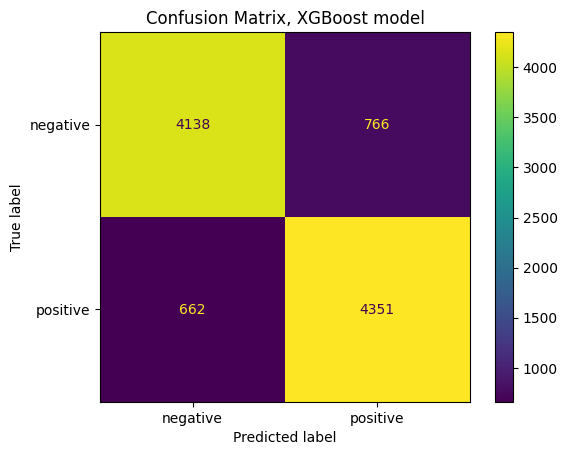

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgbo, X_test, y_test,
                                                    display_labels = ('negative', 'positive'))
plt.title('Confusion Matrix, XGBoost model')
plt.show()

In [ ]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4904
           1       0.85      0.87      0.86      5013

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

